### MNIST 이미지 파일을 활용한 딥러닝 기초

* 손글씨 숫자 분류를 진행
* 앙상블 학습 기법을 활용 CNN으로 손글씨 이미지를 분류한다.

* 참고 : https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist 
    - 이후 이 프로젝트도 따로 진행할 예정입니다.

In [1]:
### 학습 데이터 Kaggle MNIST 데이터셋의 42,000 개의 이미지 파일을 활용할 것임
### 원본 이미지를 회줜, 크기 조정, 이동 등의 변형을 거쳐 추가 생성한 2500만 개의 이미지를 활용

In [2]:
# import 패키지
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt


In [3]:
# 데이터 불러오기

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [4]:
# 신경망 형성을 위한 작업을 실시

# train data 에서 타겟(label)을 추출하고 저장
Y_train = train["label"]

# 훈련 데이터셋에서 타겟(label)을 제외한 나머지 데이터를 추출
X_train = train.drop(labels = ["label"],axis = 1)

# 이미지 픽셀 값의 범위를 0 ~ 255 사이에서 0 ~ 1 사이로 정규화함
X_train = X_train / 255.0
X_test = test / 255.0

# 이미지 데이터의 형태를 다시 구성. 각 이미지는 28x28 크기의 픽셀 값을 가지므로 이를 28x28x1의 3차원 배열 형태로 변환하는 작업을 거침
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

# 훈련 데이터의 레이블을 원-핫 인코딩(one-hot encoding)하여 변수 Y_train에 저장
# 각 숫자에 해당하는 클래스를 나타내는 범주형 데이터로 변환될 것임
# 여기서 num_classes 는 클래스의 수임
Y_train = to_categorical(Y_train, num_classes = 10)

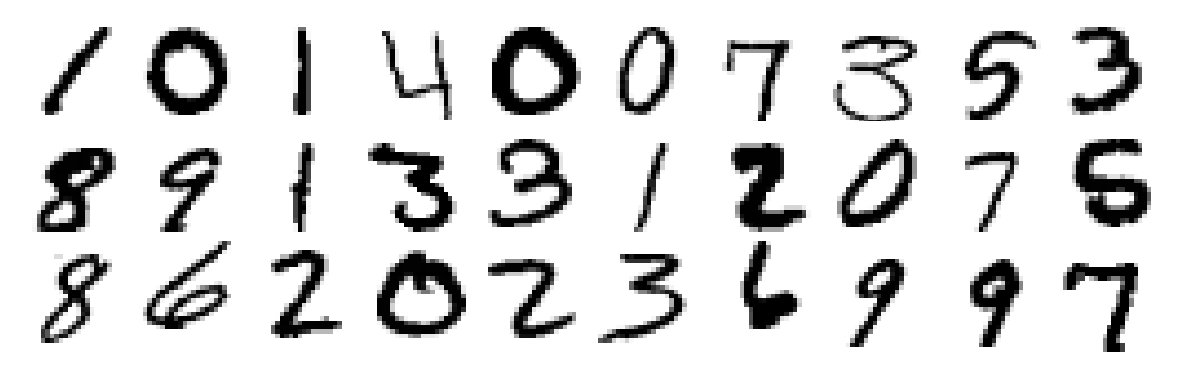

In [5]:
# 데이터셋에서 추출된 이미지를 시각화
plt.figure(figsize=(15,4.5))

# 30개의 이미지를 시각화하는 작업
for i in range(30):  

    # 3행 10열의 그리드에서 현재 순번에 해당하는 위치를 지정/ 3개의 행으로 구성하는 그림을 그리겠다는 의미
    plt.subplot(3, 10, i+1)

    # reshape((28,28))를 사용하여 이미지의 형태를 28x28 크기로 변환
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)

    plt.axis('off')

plt.subplots_adjust(wspace=-0.1, hspace=-0.1)

plt.show()

In [6]:
# 데이터 증강을 통해 많은 이미지를 생성함.
datagen = ImageDataGenerator(
        rotation_range=10,  # 회전을 통해 이미지 생성
        zoom_range = 0.10,  # 확대 or 축소
        width_shift_range=0.1, # 이미지를 좌우로 이동시킬 범위
        height_shift_range=0.1) # 이미지를 상하로 이동시킬 범위

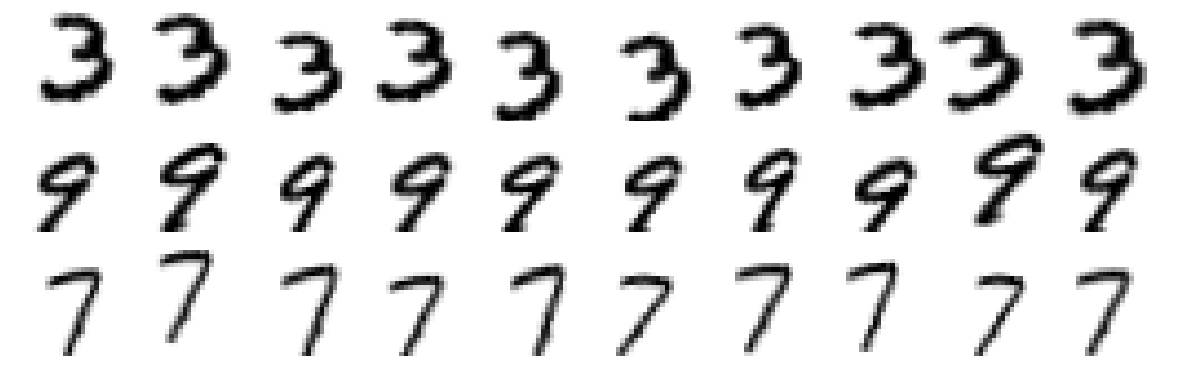

In [7]:
# 이미지 데이터의 형태를 다시 구성. 각 이미지는 28x28 크기의 픽셀 값을 가지므로 이를 28x28x1의 3차원 배열 형태로 변환하는 작업을 거침
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))

plt.figure(figsize=(15,4.5))
# 추가한 이미지를 시각화
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [8]:
### CNN 연결망 구성하기

# CNN 구성
nets = 15 # 15개의 모델을 생성
model = [0] *nets # 15개의 모델을 담을 리스트를 초기화함

# nets 의 수만큼 반복하여 각 모델을 생성함
for j in range(nets):
    # 각 모델을 Sequential 모델로 초기화
    model[j] = Sequential()

    # 컨볼루션 층을 추가함. 각 층은 relu 활성화 함수를 사용, 입력 이미지의 크기를 지정해준다.
    # 32 는 층의 필터 개수를 의미함, 커널의 크기는 3이므로 3X3 크기의 커널을 사용
    # relu 는 활성화함수로 Rectified Linear Unit 을 의미함 -> 따로 찾아서 검색이 필요
    # 입력이미지의 형태를 지정해준다. 위에서 지정한 것과 같이 28X28 의 흑백이미지를 처리하기 위해 밑에와 같이 설정해줌
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    
    # 배치 정규화 층을 추가한다. 네트워크의 안정성과 학습 속도를 향상시키기 위함이다.
    model[j].add(BatchNormalization())
    
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    
    # dropout 층을 추가. 과적합을 방지하기 위해서 임의의 뉴런을 제거하는 과정, 0.4 는 dropout 비율을 의미 40% 뉴런이 무작위로 제거됨
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())

    # Conv2D 층의 출력을 1차원으로 변환하는 작업임
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))

    # 완전 연결 층을 추가함, 최종 출력을 생성하기 위함.
    # 10 은 출력의 개수를 의미, 여기서는 10개의 클래스를 구분하는 작업이므로 10으로 설정
    # 출력층 활성화 함수로는 softmax 를 사용
    model[j].add(Dense(10, activation='softmax'))

    # adam 옵티마이저를 사용, 손실함수는 categorical_crossentropy, 평가 지표로는 정확도를 사용한다.
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

## 이 코드의 Conv2D 특징

* **더 작은 필터 적용:** 단일 5x5 필터 대신 3x3 필터 두 개를 쌓아 사용합니다.
* **학습 가능한 풀링:** 풀링 레이어 대신 스트라이드(stride) 2를 사용하는 컨볼루션 연산을 사용합니다. 이는 학습 가능한 풀링 레이어로 변환됩니다.
* **ReLU 활성화 함수 사용:** 시그모이드 함수 대신 ReLU 활성화 함수를 사용합니다.
* **배치 정규화 추가:** 학습 과정을 안정화시키는 배치 정규화 기법을 추가합니다.
* **드롭아웃 추가:** 과적합을 방지하기 위해 드롭아웃 기법을 추가합니다.

In [9]:
### 15 개의 cnn 훈련

# 학습률을 조절하기 위한 콜백 함수를 생성
# 이 함수는 각 epochs 마다 학습률을 조정, 여기서는 초기 학습률을 0.001 로 지정하고 매 epochs 마다 0.95 씩 학습률을 감소시킴
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 신경망 train 작업 실시
# 훈련된 각 모델의 히스토리(학습 곡선)를 저장할 리스트를 초기화
history = [0] * nets

epochs = 15 # 반복할 epochs 수

# 모든 모델에 대해서 반복하기 위한 for 구문
for j in range(nets):

    # train, val(검증) 데이터로 분할함 val 데이터는 모델의 성능을 평가하는데 사용됨
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)

    # 모델을 훈련시킴
    # fit_generator 매서드를 사용해 데이터 증강을 적용한 train data를 사용
    # datagen.flow 매서드는 이미지 데이터에 데이터 증강을 적용하고 배치로 나누어 제공함
    # steps_per_epoch 은 각 epoch 에서 배치 수를 지정
    # validation_data 는 검증 데이터를 지정
    # callbacks는 콜백 함수를 지정, 여기서는 학습률을 조정하는 콜백 함수를 사용
    # verbose는 훈련 과정의 로그를 출력할지 여부를 지정
    history[j] = model[j].fit(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))




CNN 1: Epochs=15, Train accuracy=0.98884, Validation accuracy=0.99381
CNN 2: Epochs=15, Train accuracy=0.98980, Validation accuracy=0.99405
CNN 3: Epochs=15, Train accuracy=0.98898, Validation accuracy=0.99500
CNN 4: Epochs=15, Train accuracy=0.98911, Validation accuracy=0.99500
CNN 5: Epochs=15, Train accuracy=0.98940, Validation accuracy=0.99667
CNN 6: Epochs=15, Train accuracy=0.98898, Validation accuracy=0.99452
CNN 7: Epochs=15, Train accuracy=0.98916, Validation accuracy=0.99333
CNN 8: Epochs=15, Train accuracy=0.98972, Validation accuracy=0.99262
CNN 9: Epochs=15, Train accuracy=0.99083, Validation accuracy=0.99214
CNN 10: Epochs=15, Train accuracy=0.98956, Validation accuracy=0.99381
CNN 11: Epochs=15, Train accuracy=0.98882, Validation accuracy=0.99524
CNN 12: Epochs=15, Train accuracy=0.98985, Validation accuracy=0.99310
CNN 13: Epochs=15, Train accuracy=0.99001, Validation accuracy=0.99452
CNN 14: Epochs=15, Train accuracy=0.98929, Validation accuracy=0.99476
CNN 15: Epoch

In [10]:
# 앙상블 방법을 사용, 여러 개의 학습된 신경망 모델을 조합하여 최종 예측을 생성, 그 결과를 제출용 CSV 파일로 저장하는 작업을 수행
# results 배여을 초기화 - 최종 예측 결과를 저장
# 각 신경망 모델에 대해서 predict 를 진행/X_test 의 행 수와 클래스를 가진 0으로 채워진 배열을 생성
results = np.zeros( (X_test.shape[0],10) )

# 모든 신경망 모델에 대해서 반복을 진행함
for j in range(nets):
    # 각 신경망 모델에 대해서 predict 를 진행
    results = results + model[j].predict(X_test)

# 각 행에 대해 가장 높은 확률을 가진 클래스의 인덱스를 찾는다. 
# argmax 를 사용 각 행에서 최대값을 찾는다.
results = np.argmax(results,axis = 1)

# results 배열에서 결과를 추출, pd.Series 객체로 변환해줌, 이 때 열의 이름을 Label 로 성정함.
results = pd.Series(results,name="Label")

# ImageId와 예측된 레이블을 포함하는 데이터프레임을 생성, pd.concat 함수를 사용하여 두 개의 시리즈를 열 방향으로 결합한다.
# ImageId는 1부터 28000까지의 순차적인 정수이며, 이는 Kaggle에서 제공하는 테스트 데이터의 이미지 번호를 나타낸다.
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

# 이를 csv 로 저장하고 인덱스는 저장하지 않음
submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)

875/875 [==============================] - 4s 4ms/step


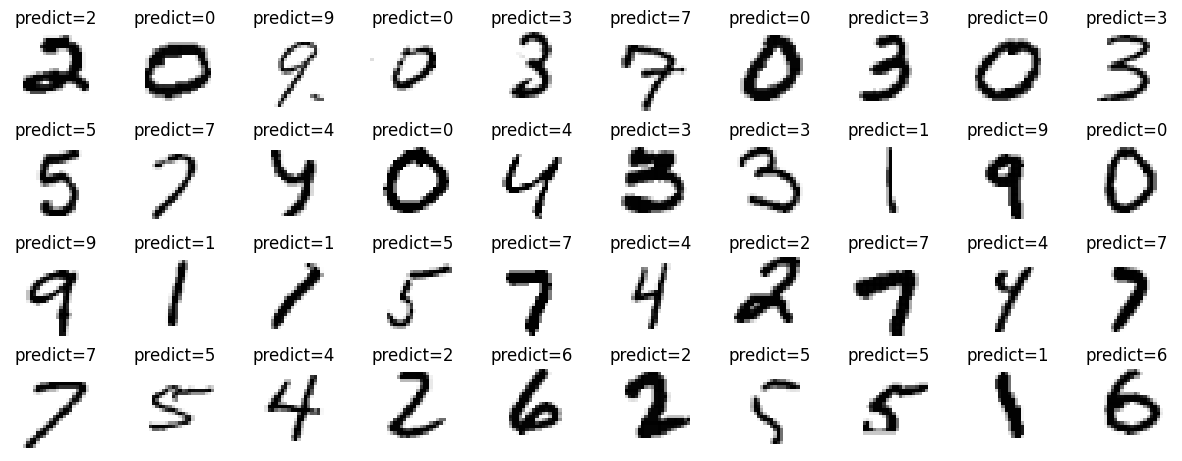

In [11]:
# 예측을 시각화하는 작업
plt.figure(figsize=(15,6))

# 40개의 이미지에 대해서 반복함
for i in range(40):  

    # 4행 10열의 서브플롯 중 현재 해당하는 순번에 해당하는 위치를 설정해줌 - i 순서대로 이미지를 그린다고 보면됨
    plt.subplot(4, 10, i+1)

    # 현재 순번에 해당하는 테스트 이미지를 28X28 크기로 변환하여 시각화
    plt.imshow(X_test[i].reshape((28,28)),cmap=plt.cm.binary)

    # 예측된 레이블을 제목으로 표시해줌
    plt.title("predict=%d" % results[i],y=0.9)

    # 축을 표시하지 않음
    plt.axis('off')

# 플롯들 간에 간격을 조절
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()